Shape of X: (4200, 2)
Shape of y: (4200,)


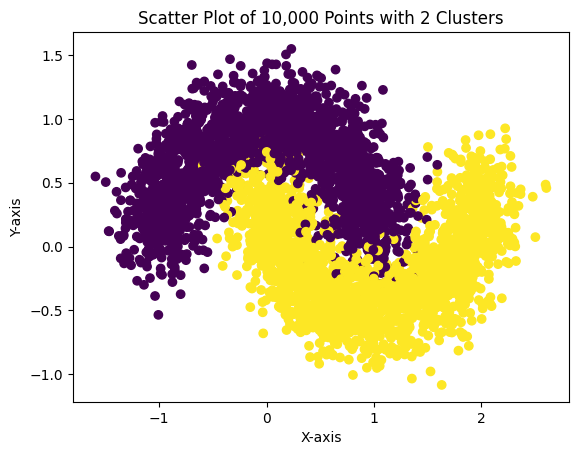

In [204]:
import numpy as np
import scipy
import time
from sklearn.datasets import make_blobs, make_moons
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

USE_LIPSCHITZ_CONSTANT = True
OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM = False
OUTPUT_STEP = 0.1
N_SAMPLES = 4200
PARTITION = int(N_SAMPLES*0.1)
NUM_ITERS = 60
EPSILON = 1e-5
PLOT_DPI = 150
OPTIMIZE_RANDOM = False

# Set random seed for reproducibility
np.random.seed(420)

# Create dataset with 10,000 points and 2 clusters
#X, y = make_blobs(n_samples=N_SAMPLES, centers=2, cluster_std=1.5)
X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=420)
y = np.where(y == 0, -1, y)

# Print the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Create scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y)

# Add axis labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of 10,000 Points with 2 Clusters')

# Show the plot
plt.show()


In [174]:
import collections

# Points initialization
labeled_X = np.array(X[:PARTITION])
unlabeled_X = np.array(X[PARTITION:])

unlabeled_X.shape

# Label initialization
y_labeled = np.array(y[:PARTITION])
collections.Counter(y_labeled)

y_unlabeled_target = np.array(y[PARTITION:])

y_unlabeled_initial = np.random.choice([-1,1], size = (len(unlabeled_X,)))

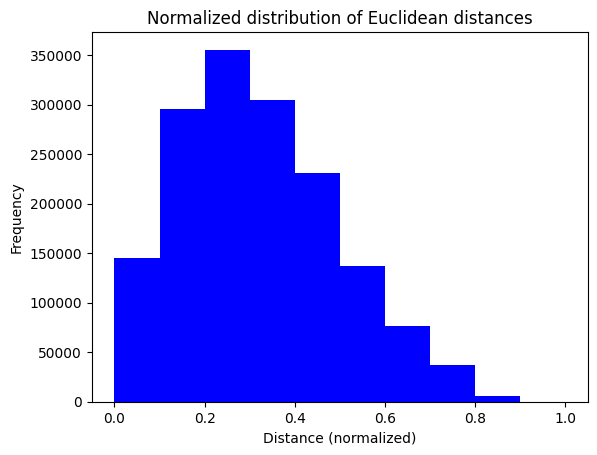

(420, 3780)

In [175]:
import math
import seaborn as sns

labeled_distances = cdist(labeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(labeled_distances)
labeled_normalized_distances = labeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(labeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

len(labeled_distances[0])

labeled_dist_matrix = np.array(labeled_distances)

labeled_dist_matrix.shape

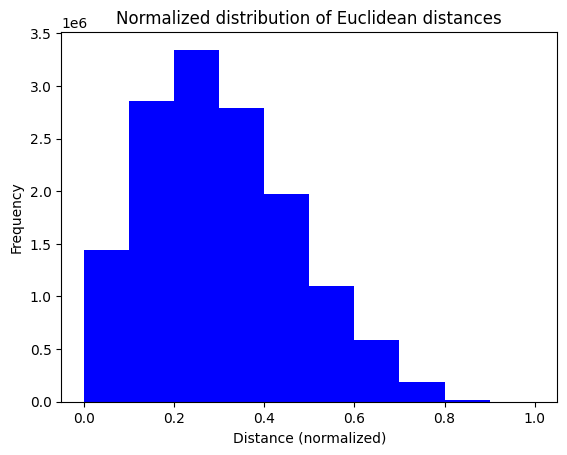

(3780, 3780)

In [176]:
unlabeled_distances = cdist(unlabeled_X, unlabeled_X)

# Normalize the distances
max_distance = np.max(unlabeled_distances)
unlabeled_normalized_distances = unlabeled_distances / max_distance

# Plot the normalized distribution of distances using a histogram
plt.hist(unlabeled_normalized_distances.flatten(), bins=10, color='blue')

# Set the x and y axis labels and title
plt.xlabel('Distance (normalized)')
plt.ylabel('Frequency')
plt.title('Normalized distribution of Euclidean distances')

# Show the plot
plt.show()

unlabeled_distances.shape


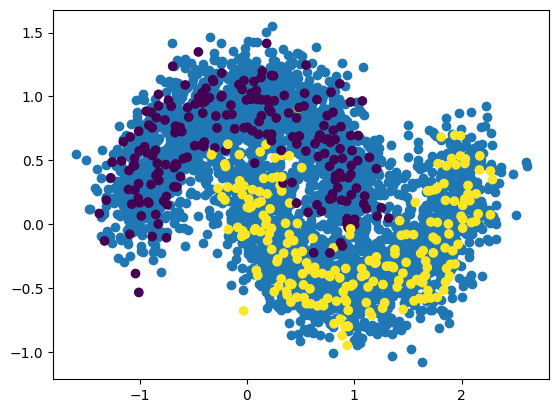

In [177]:
plt.scatter(unlabeled_X[:, 0], unlabeled_X[:, 1])
plt.scatter(labeled_X[:, 0], labeled_X[:, 1], c=y_labeled)

plt.show()

## Calculating Weights

For the weights, the following is the function that has been choosen:

$$
dist(a,b) = e^{-10 ||a-b||^2_2}
$$

In [178]:
def weight(dist):
    return math.e**(-10*dist**2)

In [179]:
%%time
print("Calculating weights between labeled points and unlabeled points")
labeled_unlabeled_weights = np.vectorize(weight)(labeled_normalized_distances)
print('Done')

print("Calculating weights between unlabeled points and unlabeled points")
unlabeled_unlabeled_weights = np.vectorize(weight)(unlabeled_normalized_distances)
print('Done')

Calculating weights between labeled points and unlabeled points
Done
Calculating weights between unlabeled points and unlabeled points
Done
CPU times: user 7.88 s, sys: 755 ms, total: 8.64 s
Wall time: 8.84 s


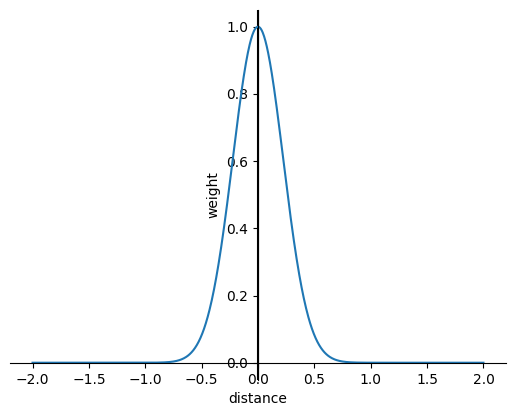

In [180]:
X = np.linspace(-2, 2, 1000)
plt.figure(dpi=100)
ax = plt.gca()
ax.legend_= None
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.set_ylabel('weight')
ax.set_xlabel('distance')
ax.axvline(x=0, color='k')
ax.plot(X, [weight(d) for d in X], label="asd")

The following are two implementations of the loss function:
$$
f(y) = \sum_{i=0}^l\sum_{j=0}^u w_{ij}(y^j -\bar{y}^i)^2 + \frac{1}{2} \sum_{i=0}^u\sum_{j=0}^u \bar{w}_{ij}(y^j -y^i)^2
$$
the following function is using linear algebra and Numpy to calcolate it, in order to have decent performance

In [181]:
def loss(labeled, unlabeled):
    Y = np.copy(unlabeled).astype("float64").reshape((-1,1))
    Y_bar = np.copy(labeled).astype("float64").reshape((-1,1))

    Y_minus_Y_bar = Y-Y_bar.T
    Y_minus_Y_bar_sq = np.power(Y_minus_Y_bar, 2)
    labeled_unlabeled_loss_matrix = Y_minus_Y_bar_sq * labeled_unlabeled_weights.T
    labeled_unlabeled_loss = np.sum(labeled_unlabeled_loss_matrix)

    Y_minus_Y = Y-Y.T
    Y_minus_Y_sq = np.power(Y_minus_Y, 2)
    unlabeled_unlabeled_loss_matrix = Y_minus_Y_sq * unlabeled_unlabeled_weights.T
    unlabeled_unlabeled_loss = np.sum(unlabeled_unlabeled_loss_matrix)

    return labeled_unlabeled_loss + unlabeled_unlabeled_loss/2

The following is a function used to calcolate the accuracy, comparing the targets and the current estimation (it's necessary in order to take care of the fact that the current is composed by number in $R \in\ [-1, 1]$ where the target is in $\{-1, 1\}$)

In [182]:
def accuracy_round(current):
    return np.sum(
        np.equal(
            (current/2 + .5).round() * 2 - 1,
            y_unlabeled_target
        )
    ) / len(y_unlabeled_target)
max_loss = np.sum(labeled_unlabeled_weights) * 4 + np.sum(unlabeled_unlabeled_weights) * 2
def accuracy_loss(current):
    return 1 - loss(y_labeled, current) / max_loss

initial_distance = np.linalg.norm(y_unlabeled_initial - y_unlabeled_target, ord=2)
def accuracy_norm(current):
    current_distance = np.linalg.norm(current - y_unlabeled_target, ord=2)
    return 1 - current_distance / initial_distance

def accuracy(current):
    return accuracy_round(current) #loss(y_labeled, current)

Those functions are used to calculate the Hessian matrix and the Lipschitz constat for the whole problem, and for the single variable.
The Hessian is calculated as follows:
$$
\begin{align*}
\text{with: } k\neq j \rightarrow \nabla_{y^jy^k}f(j) &=\bar{w}_{kj}\\
\text{with: } k = j \rightarrow \nabla_{y^jy^j}f(j) &= 2(\sum_{i=0}^lw_{ij}) + (\sum_{i=0}^u\bar{w}_{ij}) - \bar{w}_{jj} \\
\end{align*}
\\
\[
  Hessian_{n\times n} =
  \left[ {\begin{array}{cccc}
    2(\sum_{i=0}^lw_{i1}) + (\sum_{i=0}^u\bar{w}_{i1}) - \bar{w}_{11} & -\bar{w}_{12} & \cdots & -\bar{w}_{1n}\\
    -\bar{w}_{21} & 2(\sum_{i=0}^lw_{i2}) + (\sum_{i=0}^u\bar{w}_{i2}) - \bar{w}_{22} & \cdots & -\bar{w}_{2n}\\
    \vdots & \vdots & \ddots & \vdots\\
    -\bar{w}_{n1} & -\bar{w}_{n2} & \cdots & 2(\sum_{i=0}^lw_{in}) + (\sum_{i=0}^u\bar{w}_{in}) - \bar{w}_{nn}\\
  \end{array} } \right]
\]

$$


### Hessian and constants

In [183]:
%%time
def hessian_matrix(w_unlabeled_unlabeled, w_labeled_unlabeled):
    mat = np.copy(-w_unlabeled_unlabeled)
    for i in range(len(y_unlabeled_target)):
        if i % (len(y_unlabeled_target) * OUTPUT_STEP) == 0 :
            print(f"{int(i/len(y_unlabeled_target)*100):02}% ... ", end="")
        mat[i][i] = 2 * np.sum(labeled_unlabeled_weights[:,i]) + np.sum(unlabeled_unlabeled_weights[:,i]) - unlabeled_unlabeled_weights[i][i]
    print()
    return mat

def estimate_lipschitz_constant(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(len(hessian)-1, len(hessian)-1))[0][0]
def estimate_degree_strongly_convex(hessian):
    return scipy.linalg.eigh(hessian, subset_by_index=(0,0))[0][0]

if USE_LIPSCHITZ_CONSTANT:
    print("Calculating the Hessian matrix")
    hessian = hessian_matrix(unlabeled_unlabeled_weights, labeled_unlabeled_weights)
    print("Calculating sigma (strongly convex)")
    sigma = estimate_degree_strongly_convex(hessian)
    strongly_convex = sigma > 0
    print(f"Sigma: {sigma}, {'' if strongly_convex else 'not'} strongly convex")
    print("Estimating Lipschitz constant for the whole function")
    L = estimate_lipschitz_constant(hessian)
    print(f"Lipschitz constant: {L}")
    print("Estimating Lipschitz constant for each single variable")
    Li = np.array([hessian[i][i] for i in range(len(hessian))], dtype='float64') \
        if OPTIMIZE_LIPSCHITZ_CONSTANT_FOR_BCGM \
        else np.repeat(L, len(hessian))
else:
    print("Using fixed step size")
    sigma = 0
    strongly_convex = False
    L = 1/STEP_SIZE
    Li = np.repeat(L, len(y_unlabeled_target))
print("Done")

Calculating the Hessian matrix
00% ... 10% ... 20% ... 30% ... 40% ... 50% ... 60% ... 70% ... 80% ... 90% ... 
Calculating sigma (strongly convex)
Sigma: 362.38721224670905,  strongly convex
Estimating Lipschitz constant for the whole function
Lipschitz constant: 2768.173356352851
Estimating Lipschitz constant for each single variable
Done
CPU times: user 44.2 s, sys: 29.9 s, total: 1min 14s
Wall time: 13.8 s


Following are some constant that are going to be used in the gradient, since it can rewritten in a format which allows to avoid having to redo those calculation each time

In [184]:
print("Calculating coefficients of the gradient")
sum_row_label_unlabel = np.sum(labeled_unlabeled_weights, axis=0).reshape((-1,1))
sum_row_unlabel_unlabel = np.sum(unlabeled_unlabeled_weights, axis=0).reshape((-1,1))
grad_first_coeff_vec = (2 * sum_row_label_unlabel + sum_row_unlabel_unlabel)
grad_second_coeff_vec = 2 * np.multiply(
    y_labeled.reshape((-1,1)),
    labeled_unlabeled_weights
).sum(0).reshape((-1,1))
print("Done")

Calculating coefficients of the gradient
Done


## Gradient Descent Methods

Following is the function used to calculate the gradient, which for a single variable is:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})y^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [185]:
def gradient_semi_iterative(labeled, unlabeled):
    grad = np.array([], dtype=float)
    for j in range(len(unlabeled)):
        tot_labeled_unlabeled = np.sum((unlabeled[j] - labeled) * labeled_unlabeled_weights.T[j])
        tot_unlabeled_unlabeled = np.sum((unlabeled[j] - unlabeled) * unlabeled_unlabeled_weights.T[j])
        grad = np.append(grad, tot_labeled_unlabeled * 2 + tot_unlabeled_unlabeled)
    return grad

def gradient_iterative(labeled, unlabeled):
    grads = []
    for j in range(len(unlabeled)):
        grad = 0
        for i in range(len(labeled)):
            grad += 2 * labeled_unlabeled_weights[i][j] * (unlabeled[j] - labeled[i])
        for i in range(len(unlabeled)):
            grad += unlabeled_unlabeled_weights[i][j] * (unlabeled[j] - unlabeled[i])
        grads.append(grad)
    return np.array(grads)

def gradient(unlabeled):
    unlabeled = unlabeled.reshape((-1,1))
    third_coeff = np.multiply(
        unlabeled,
        unlabeled_unlabeled_weights
    ).sum(0).reshape((-1,1))
    return (grad_first_coeff_vec * unlabeled - grad_second_coeff_vec - third_coeff).reshape((-1,))

### Gradient Descent

Creating a copy of the defined initialization, in order to have the same also in the following algorithms

In [186]:
y_unlabeled_gd = np.copy(y_unlabeled_initial)

In [187]:
%%time
ticks_gd = [0]
accuracies_gd = [accuracy(y_unlabeled_gd)]
losses_gd = [loss(y_labeled, y_unlabeled_gd)]
init_time = time.time() * 1000

for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd = y_unlabeled_gd - 1/L * grad
    accuracies_gd.append(accuracy(y_unlabeled_gd))
    losses_gd.append(loss(y_labeled, y_unlabeled_gd))
    ticks_gd.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd))}
Loss: {loss(y_labeled, y_unlabeled_gd)}
""")

00% - iter 0 / 60 - final accuracy 49.07% - loss 1133068.23
10% - iter 6 / 60 - final accuracy 80.98% - loss 683720.90
20% - iter 12 / 60 - final accuracy 80.98% - loss 685005.13
30% - iter 18 / 60 - final accuracy 80.93% - loss 685144.47
40% - iter 24 / 60 - final accuracy 80.87% - loss 685157.42
50% - iter 30 / 60 - final accuracy 80.93% - loss 685158.53
60% - iter 36 / 60 - final accuracy 80.87% - loss 685158.61
70% - iter 42 / 60 - final accuracy 80.90% - loss 685158.61
80% - iter 48 / 60 - final accuracy 80.93% - loss 685158.61
90% - iter 54 / 60 - final accuracy 80.93% - loss 685158.61

Final accuracy: 80.93%
Norm gradient: 0.16299655258182258
Loss: 685158.6121009034

CPU times: user 48.5 s, sys: 471 ms, total: 49 s
Wall time: 48.7 s


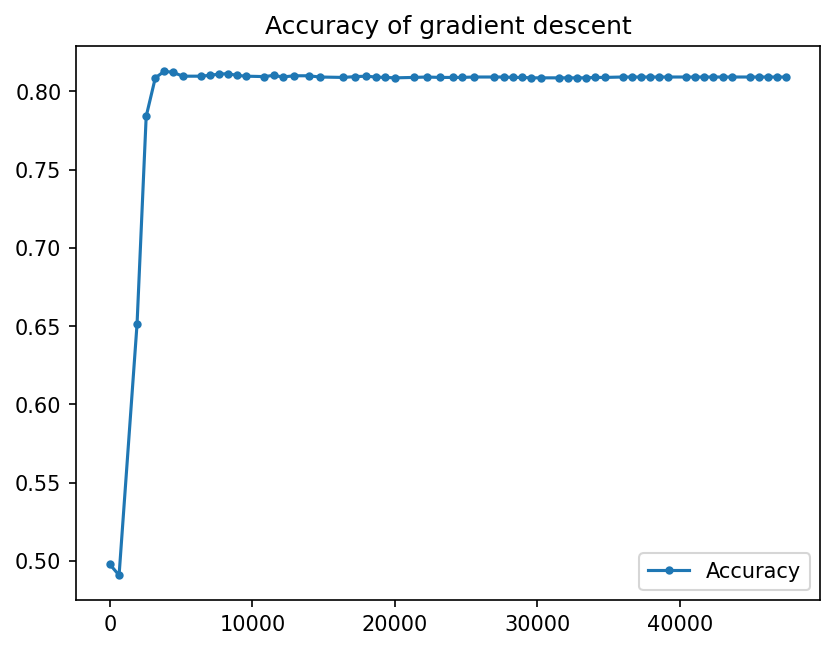

In [188]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent")
plt.plot(ticks_gd, accuracies_gd, marker='.')
plt.legend(["Accuracy"])

### Gradient Descent with improved rate

This implementation of the GD algorithm with use:
$$
\alpha_k = $\frac{2}{L+sigma}$
$$
in case the problem is strongly convex

In [189]:
y_unlabeled_gd_improved = np.copy(y_unlabeled_initial)

In [190]:
%%time
ticks_gd_improved = [0]
accuracies_gd_improved = [accuracy(y_unlabeled_gd_improved)]
losses_gd_improved = [loss(y_labeled, y_unlabeled_gd_improved)]
init_time = time.time() * 1000
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_improved)

    if EPSILON >= np.linalg.norm(grad):
        break

    y_unlabeled_gd_improved = y_unlabeled_gd_improved - (2 if strongly_convex else 1)/(L + (sigma if strongly_convex else 0)) * grad
    accuracies_gd_improved.append(accuracy(y_unlabeled_gd_improved))
    losses_gd_improved.append(loss(y_labeled, y_unlabeled_gd_improved))
    ticks_gd_improved.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_improved[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_improved):05.2f}")
print(f"""
Final accuracy: {round(accuracies_gd_improved[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_improved))}
Loss: {loss(y_labeled, y_unlabeled_gd_improved)}
""")

00% - iter 0 / 60 - final accuracy 56.27% - loss 2297948.71
10% - iter 6 / 60 - final accuracy 82.49% - loss 697002.79
20% - iter 12 / 60 - final accuracy 80.77% - loss 685406.47
30% - iter 18 / 60 - final accuracy 80.95% - loss 685165.60
40% - iter 24 / 60 - final accuracy 80.95% - loss 685158.85
50% - iter 30 / 60 - final accuracy 80.93% - loss 685158.62
60% - iter 36 / 60 - final accuracy 80.93% - loss 685158.61
70% - iter 42 / 60 - final accuracy 80.93% - loss 685158.61
80% - iter 48 / 60 - final accuracy 80.93% - loss 685158.61
90% - iter 54 / 60 - final accuracy 80.93% - loss 685158.61

Final accuracy: 80.93%
Norm gradient: 0.0015208222348700219
Loss: 685158.6121494548

CPU times: user 46.9 s, sys: 124 ms, total: 47 s
Wall time: 47.1 s


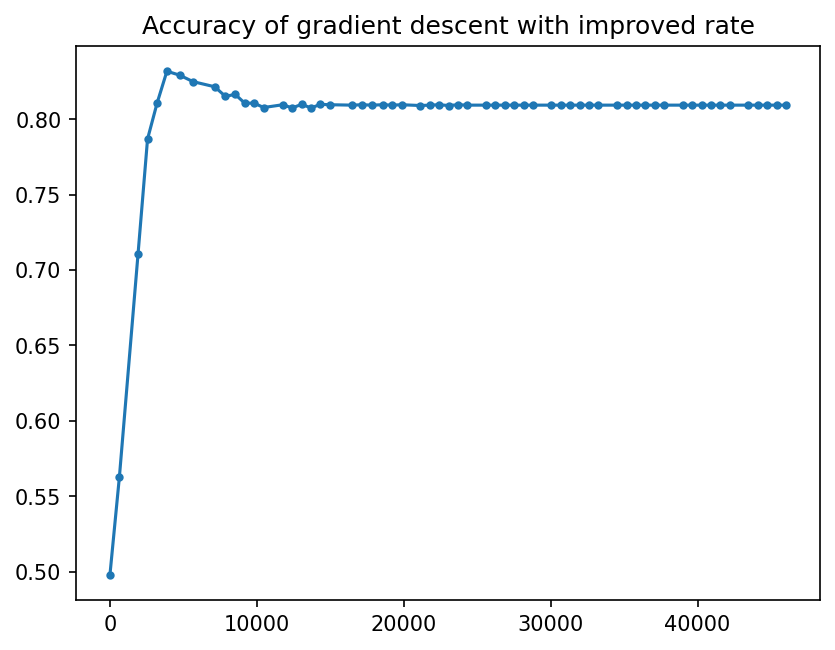

In [191]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of gradient descent with improved rate")
plt.plot(ticks_gd_improved, accuracies_gd_improved, marker='.')

### Heavy ball

In [192]:
y_unlabeled_gd_hb_previous = y_unlabeled_gd_hb = np.copy(y_unlabeled_initial)

In [194]:
%%time
ticks_gd_hb = [0]
accuracies_gd_hb = [accuracy(y_unlabeled_gd_hb)]
losses_gd_hb = [loss(y_labeled, y_unlabeled_gd_hb)]
init_time = time.time() * 1000
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    grad = gradient(y_unlabeled_gd_hb)
    if EPSILON >= np.linalg.norm(grad):
        break

    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    momentum = Beta * (y_unlabeled_gd_hb - y_unlabeled_gd_hb_previous)

    old_y_unlabeled_gd_hb = np.copy(y_unlabeled_gd_hb)
    y_unlabeled_gd_hb = y_unlabeled_gd_hb - 1/L * grad + momentum
    y_unlabeled_gd_hb_previous = old_y_unlabeled_gd_hb

    accuracies_gd_hb.append(accuracy(y_unlabeled_gd_hb))
    losses_gd_hb.append(loss(y_labeled, y_unlabeled_gd_hb))
    ticks_gd_hb.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_hb[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_hb):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_hb[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_hb))}
Loss: {loss(y_labeled, y_unlabeled_gd_hb)}
""")

00% - iter 0 / 60 - final accuracy 65.13% - loss 745540.66
10% - iter 6 / 60 - final accuracy 80.61% - loss 689260.58
20% - iter 12 / 60 - final accuracy 81.03% - loss 685249.26
30% - iter 18 / 60 - final accuracy 80.95% - loss 685368.78
40% - iter 24 / 60 - final accuracy 80.93% - loss 685353.33
50% - iter 30 / 60 - final accuracy 81.01% - loss 685038.34
60% - iter 36 / 60 - final accuracy 80.85% - loss 685366.87
70% - iter 42 / 60 - final accuracy 80.93% - loss 685023.33
80% - iter 48 / 60 - final accuracy 80.93% - loss 685289.03
90% - iter 54 / 60 - final accuracy 81.01% - loss 685095.79

Final accuracy: 80.93%
Norm gradient: 120.2783643331606
Loss: 685236.6712643739

CPU times: user 45.9 s, sys: 104 ms, total: 46 s
Wall time: 45.9 s


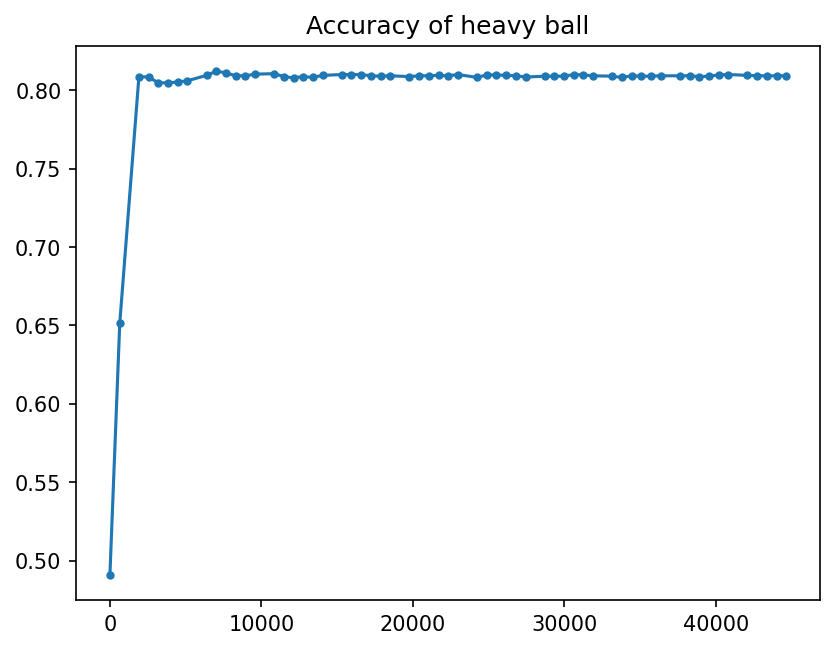

In [195]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of heavy ball")
plt.plot(ticks_gd_hb, accuracies_gd_hb, marker='.')

### Accelerated Gradient

In [196]:
y_unlabeled_gd_accelerated_previous = y_unlabeled_gd_accelerated = np.copy(y_unlabeled_initial)

In [198]:
%%time
ticks_gd_accelerated = [0]
accuracies_gd_accelerated = [accuracy(y_unlabeled_gd_accelerated)]
init_time = time.time() * 1000
losses_gd_accelerated = [loss(y_labeled, y_unlabeled_gd_accelerated)]
Alpha = 1
for i in range(NUM_ITERS):
    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f"{int(i/NUM_ITERS*100):02}% - iter {i} / {NUM_ITERS}", end="")
    start = time.process_time()
    new_Alpha = (1 + math.sqrt(1 + 4 * Alpha**2))/2
    Beta = (Alpha - 1) / new_Alpha
    Alpha = new_Alpha
    new_position = y_unlabeled_gd_accelerated + Beta * (y_unlabeled_gd_accelerated - y_unlabeled_gd_accelerated_previous)
    grad = gradient(new_position)
    if EPSILON >= np.linalg.norm(grad):
        break

    old_y_unlabeled_gd_accelerated = np.copy(y_unlabeled_gd_accelerated)
    y_unlabeled_gd_accelerated = new_position - 1/L * grad
    y_unlabeled_gd_accelerated_previous = old_y_unlabeled_gd_accelerated

    accuracies_gd_accelerated.append(accuracy(y_unlabeled_gd_accelerated))
    losses_gd_accelerated.append(loss(y_labeled, y_unlabeled_gd_accelerated))
    ticks_gd_accelerated.append(time.time() * 1000 - init_time)

    if i % (NUM_ITERS * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_gd_accelerated[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_gd_accelerated):05.2f}")

print(f"""
Final accuracy: {round(accuracies_gd_accelerated[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_gd_accelerated))}
Loss: {loss(y_labeled, y_unlabeled_gd_accelerated)}
""")

00% - iter 0 / 60 - final accuracy 65.13% - loss 745540.66
10% - iter 6 / 60 - final accuracy 80.93% - loss 685981.96
20% - iter 12 / 60 - final accuracy 80.95% - loss 685057.63
30% - iter 18 / 60 - final accuracy 80.93% - loss 685174.36
40% - iter 24 / 60 - final accuracy 80.93% - loss 685156.60
50% - iter 30 / 60 - final accuracy 80.95% - loss 685158.73
60% - iter 36 / 60 - final accuracy 80.93% - loss 685158.68
70% - iter 42 / 60 - final accuracy 80.93% - loss 685158.58
80% - iter 48 / 60 - final accuracy 80.93% - loss 685158.62
90% - iter 54 / 60 - final accuracy 80.93% - loss 685158.61

Final accuracy: 80.93%
Norm gradient: 0.028806060230500606
Loss: 685158.6132266138

CPU times: user 46.1 s, sys: 305 ms, total: 46.5 s
Wall time: 46.6 s


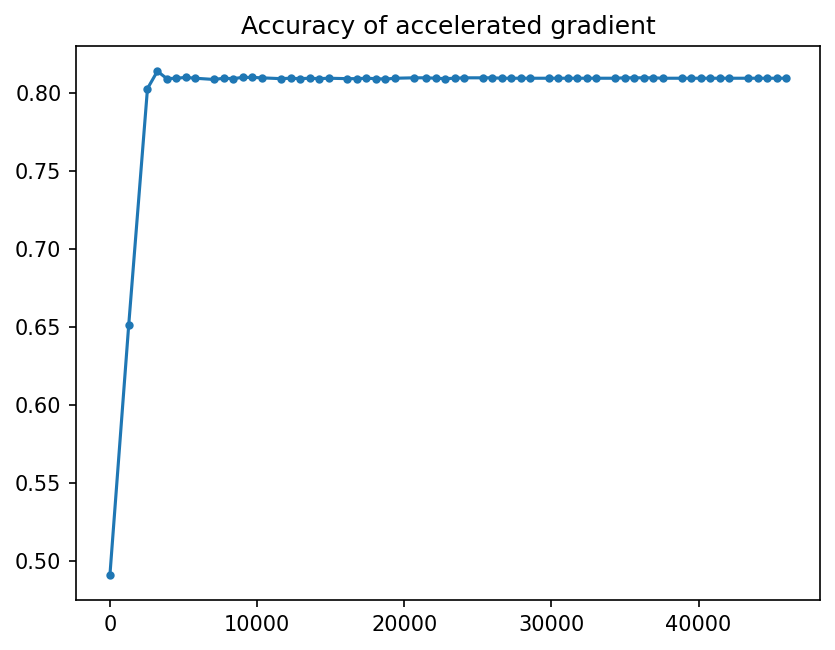

In [199]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of accelerated gradient")
plt.plot(ticks_gd_accelerated, accuracies_gd_accelerated, marker='.')

## Block Coordinate Gradient Method

Following is the function used to find the derivative in respect to a single variable:
$$
\begin{align*}
\nabla_{y^j}f(y) &= 2 \sum_{i=0}^lw_{ij}(y^j - \bar{y}^i) + \sum_{i=0}^u\bar{w}_{ij}(y^j - y^i) \\
& = (2 \sum_{i=0}^lw_{ij} + \sum_{i=0}^u\bar{w}_{ij})\bar{y}^j - 2 \sum_{i=0}^lw_{ij}\bar{y}^i - \sum_{i=0}^u\bar{w}_{ij}y^i
\end{align*}
$$

In [206]:
def derivative(unlabeled, j):
    return grad_first_coeff_vec[j] * unlabeled[j] - \
           grad_second_coeff_vec[j] - \
           np.matmul(w_unlabeled_unlabeled[:,j], unlabeled.T)

def derivative_iterative(labeled, unlabeled, j):
    tot = 0
    for i in range(len(labeled)):
        tot += 2*w_labeled_unlabeled[i][j] * (unlabeled[j] - labeled[i])
    for i in range(len(unlabeled)):
        tot += w_unlabeled_unlabeled[i][j] * (unlabeled[j] - unlabeled[i])
    return tot

def update_gradient(previous_grad, Li, index):
    global unlabeled_unlabeled_weights, grad_first_coeff_vec
    step = 1/Li[index] * previous_grad[index]
    new_grad = np.copy(previous_grad)
    new_grad += unlabeled_unlabeled_weights[index] * step
    new_grad[index] -= grad_first_coeff_vec[index] * step
    return step, new_grad

### Randomized

In [202]:
y_unlabeled_bcgd_random = np.copy(y_unlabeled_initial).astype("float64")

In [207]:
%%time
ticks_bcgd_random= [0]
accuracies_bcgd_random= [accuracy(y_unlabeled_bcgd_random)]
losses_bcgm_random = [loss(y_labeled, y_unlabeled_bcgd_random)]

optimized_sampling_probabilities = np.copy(Li) / np.sum(Li)
previous_grad_random = gradient(y_unlabeled_bcgd_random)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
indexes = np.random.choice(len(y_unlabeled_bcgd_random), max_iterations, p=optimized_sampling_probabilities)[0] \
    if OPTIMIZE_RANDOM else np.random.randint(0, len(y_unlabeled_bcgd_random), max_iterations)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = indexes[i]

    step, new_grad = update_gradient(previous_grad_random, Li, index)
    y_unlabeled_bcgd_random[index] = y_unlabeled_bcgd_random[index] - step
    previous_grad_random = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_random):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_random.append(accuracy(y_unlabeled_bcgd_random))
        losses_bcgm_random.append(loss(y_labeled, y_unlabeled_bcgd_random))
        ticks_bcgd_random.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_random[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_random):05.2f}")

print(f"""
Final accuracy: {round(accuracies_bcgd_random[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_random))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_random)}
""")

00% - iter 0 / 226800 - final accuracy 49.76% - loss 7995696.23
10% - iter 22680 / 226800 - final accuracy 79.55% - loss 703807.25
20% - iter 45360 / 226800 - final accuracy 81.08% - loss 684772.25
30% - iter 68040 / 226800 - final accuracy 81.03% - loss 685086.59
40% - iter 90720 / 226800 - final accuracy 80.95% - loss 685146.75
50% - iter 113400 / 226800 - final accuracy 80.90% - loss 685155.83
60% - iter 136080 / 226800 - final accuracy 80.90% - loss 685157.69
70% - iter 158760 / 226800 - final accuracy 80.87% - loss 685158.42
80% - iter 181440 / 226800 - final accuracy 80.93% - loss 685158.53
90% - iter 204120 / 226800 - final accuracy 80.93% - loss 685158.62

Final accuracy: 80.93%
Norm gradient: 0.3725064058873915
Loss: 685158.6123810363

CPU times: user 51.8 s, sys: 400 ms, total: 52.2 s
Wall time: 52.2 s


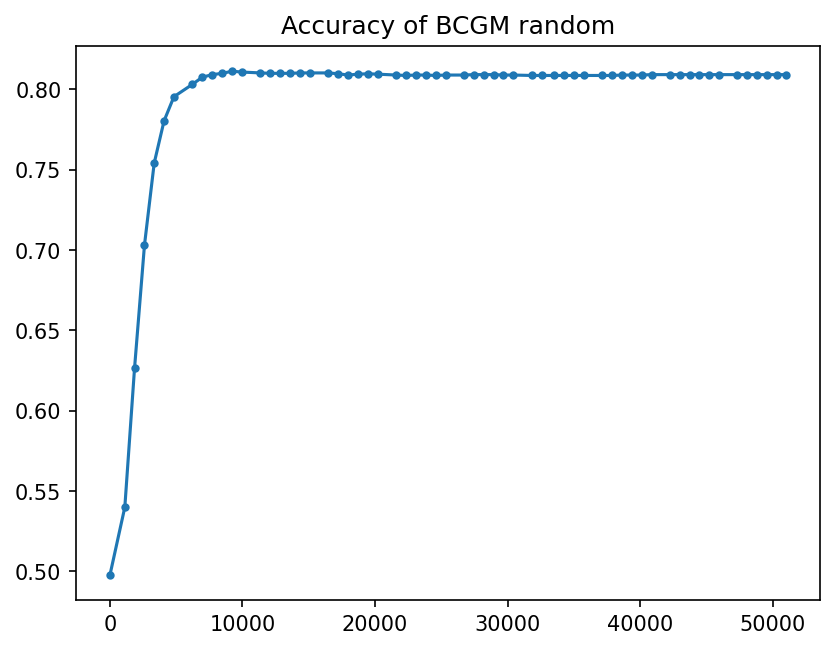

In [208]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM random")
plt.plot(ticks_bcgd_random, accuracies_bcgd_random, marker='.')

### Cyclic

In [210]:
y_unlabeled_bcgd_cyclic = np.copy(y_unlabeled_initial).astype("float64")

In [211]:
%%time
ticks_bcgd_cyclic= [0]
accuracies_bcgd_cyclic= [accuracy(y_unlabeled_bcgd_cyclic)]
losses_bcgm_cyclic = [loss(y_labeled, y_unlabeled_bcgd_cyclic)]

previous_grad_cyclic = gradient(y_unlabeled_bcgd_cyclic)
max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_cyclic)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = i % len(y_unlabeled_bcgd_cyclic)

    step, new_grad = update_gradient(previous_grad_cyclic, Li, index)
    y_unlabeled_bcgd_cyclic[index] = y_unlabeled_bcgd_cyclic[index] - step
    previous_grad_cyclic = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_cyclic):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_cyclic.append(accuracy(y_unlabeled_bcgd_cyclic))
        losses_bcgm_cyclic.append(loss(y_labeled, y_unlabeled_bcgd_cyclic))
        ticks_bcgd_cyclic.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_cyclic[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_cyclic):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_cyclic[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_cyclic))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_cyclic)}
""")

00% - iter 0 / 226800 - final accuracy 49.76% - loss 7994720.37
10% - iter 22680 / 226800 - final accuracy 81.27% - loss 684094.37
20% - iter 45360 / 226800 - final accuracy 80.90% - loss 685062.36
30% - iter 68040 / 226800 - final accuracy 80.90% - loss 685151.11
40% - iter 90720 / 226800 - final accuracy 80.87% - loss 685157.90
50% - iter 113400 / 226800 - final accuracy 80.93% - loss 685158.52
60% - iter 136080 / 226800 - final accuracy 80.93% - loss 685158.60
70% - iter 158760 / 226800 - final accuracy 80.93% - loss 685158.61
80% - iter 181440 / 226800 - final accuracy 80.93% - loss 685158.61
90% - iter 204120 / 226800 - final accuracy 80.93% - loss 685158.61

Final accuracy: 80.93%
Norm gradient: 0.0021598733171140447
Loss: 685158.6120825941

CPU times: user 51.4 s, sys: 471 ms, total: 51.9 s
Wall time: 52 s


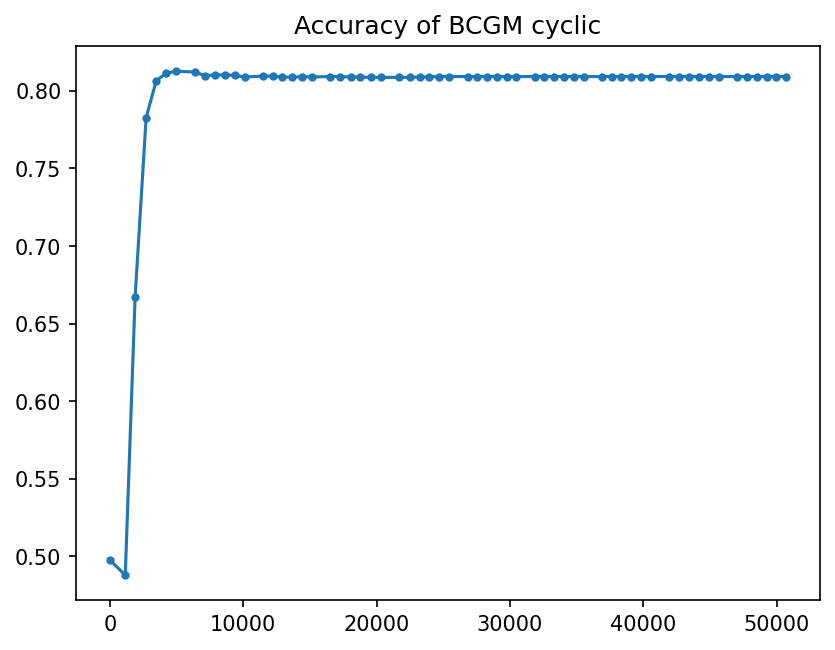

In [212]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM cyclic")
plt.plot(ticks_bcgd_cyclic, accuracies_bcgd_cyclic, marker='.')

### Gauss-Southwell

In [213]:
y_unlabeled_bcgd_gs = np.copy(y_unlabeled_initial).astype("float64")

In [214]:
%%time
ticks_bcgd_gs = [0]
accuracies_bcgd_gs = [accuracy(y_unlabeled_bcgd_gs)]
losses_bcgm_gs = [loss(y_labeled, y_unlabeled_bcgd_gs)]

max_iterations = NUM_ITERS*len(y_unlabeled_bcgd_random)
previous_grad_gs = gradient(y_unlabeled_bcgd_gs)

init_time = time.time() * 1000

for i in range(max_iterations):
    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f"{int(i/max_iterations*100):02}% - iter {i} / {max_iterations}", end="")

    index = np.argmax(np.abs(previous_grad_gs))

    step, new_grad = update_gradient(previous_grad_gs, Li, index)
    y_unlabeled_bcgd_gs[index] = y_unlabeled_bcgd_gs[index] - step
    previous_grad_gs = new_grad

    if EPSILON >= np.linalg.norm(previous_grad_gs):
        break

    if (i+1) % len(y_unlabeled_target) == 0:

        accuracies_bcgd_gs.append(accuracy(y_unlabeled_bcgd_gs))
        losses_bcgm_gs.append(loss(y_labeled, y_unlabeled_bcgd_gs))
        ticks_bcgd_gs.append(time.time() * 1000 - init_time)

    if i % (max_iterations * OUTPUT_STEP) == 0 :
        print(f" - final accuracy {(accuracies_bcgd_gs[-1])*100:05.2f}% - loss {loss(y_labeled, y_unlabeled_bcgd_gs):05.2f}")


print(f"""
Final accuracy: {round(accuracies_bcgd_gs[-1]* 100, 2)}%
Norm gradient: {np.linalg.norm(gradient(y_unlabeled_bcgd_gs))}
Loss: {loss(y_labeled, y_unlabeled_bcgd_gs)}
""")

00% - iter 0 / 226800 - final accuracy 49.76% - loss 7994538.70
10% - iter 22680 / 226800 - final accuracy 81.01% - loss 685402.73
20% - iter 45360 / 226800 - final accuracy 81.01% - loss 685175.09
30% - iter 68040 / 226800 - final accuracy 80.95% - loss 685156.61
40% - iter 90720 / 226800 - final accuracy 80.93% - loss 685158.97
50% - iter 113400 / 226800 - final accuracy 80.90% - loss 685158.69
60% - iter 136080 / 226800 - final accuracy 80.93% - loss 685158.65
70% - iter 158760 / 226800 - final accuracy 80.93% - loss 685158.61
80% - iter 181440 / 226800 - final accuracy 80.93% - loss 685158.61
90% - iter 204120 / 226800 - final accuracy 80.93% - loss 685158.61

Final accuracy: 80.93%
Norm gradient: 0.0037134430327290502
Loss: 685158.6123612963

CPU times: user 53.8 s, sys: 426 ms, total: 54.2 s
Wall time: 54.2 s


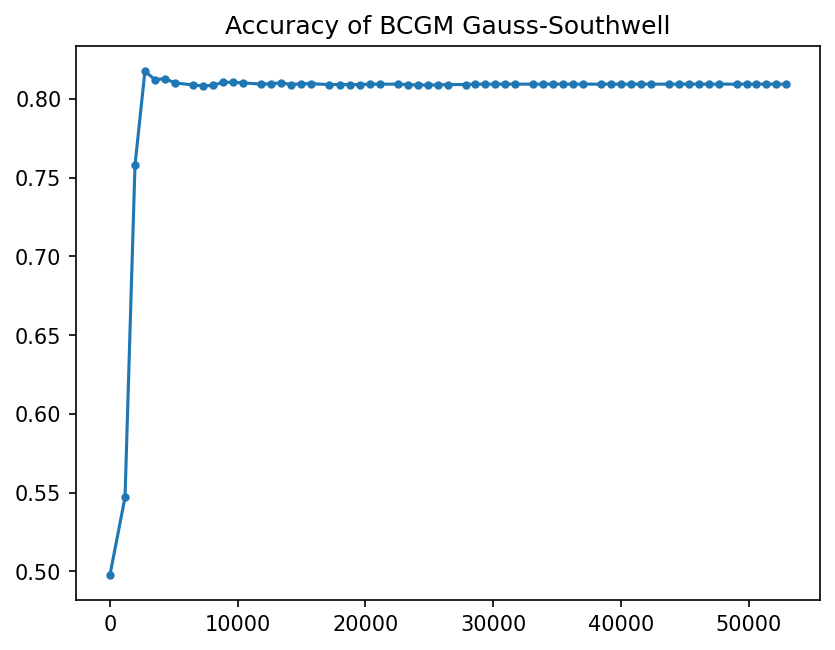

In [215]:
plt.figure(dpi=PLOT_DPI)
plt.title("Accuracy of BCGM Gauss-Southwell")
plt.plot(ticks_bcgd_gs, accuracies_bcgd_gs, marker='.')